In [46]:
import torch
import torch.nn as nn
from torch import Tensor
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [47]:
class PositionalEmbedding(nn.Module):
    def __init__(self, 
                 embedding_dim,
                 max_len=5000,
                 freq=10000.,
                ):
        super().__init__()
        pe = torch.zeros(max_len, embedding_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, embedding_dim, 2).float() *
                        (-math.log(freq) / embedding_dim))
        pe[:, 0::2] = torch.sin(position * div) # Even terms
        pe[:, 1::2] = torch.cos(position * div) # Odd terms
        pe = pe.unsqueeze(0).transpose(0,1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

In [48]:
class MultiheadedSelfAttention(nn.Module):
    def __init__(self, 
                 embed_dim, 
                 num_heads=12,
                 attn_dropout=0.,
                 proj_dropout=0.,
                 ):
        super().__init__()
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0, "Embedding dim must be divisible by number of heads."
        head_dim = embed_dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.projection = nn.Linear(embed_dim, embed_dim)
        self.proj_dropout = nn.Dropout(proj_dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, 
                                  self.num_heads, 
                                  C // self.num_heads).permute(2, # qkv
                                                               0, # batch
                                                               3, # channel
                                                               1, # num_heads
                                                               4) # embed_dim
        q, k, v = torch.chunk(qkv, 3)

        attn = torch.bmm(q, k.transpose(-2, -1)) * self.scale # <q,k> / sqrt(d)
        attn.softmax(dim=-1) # Softmax over embedding dim
        attn = self.attn_dropout(attn)

        x = torch.bmm(attn, v).transpose(1, 2).reshape(B, N, C)
        x = self.projection(x)
        x = self.proj_dropout(x)

        return x

In [49]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self,
                 embed_dim=768,
                 num_heads=12,
                 attn_dropout=0.,
                 proj_dropout=0.,
                 mlp_dropout=0.1,
                 feedforward_dim=3072,
            ):
        super().__init__()
        self.norm_1 = nn.LayerNorm(embed_dim)
        self.norm_2 = nn.LayerNorm(embed_dim)
        self.MHA = MultiheadedSelfAttention(embed_dim,
                                        num_heads,
                                        attn_dropout,
                                        proj_dropout,
                   )
        self.ff = nn.Sequential(nn.Linear(embed_dim, feedforward_dim),
                                nn.GELU(),
                                nn.Dropout(mlp_dropout),
                                nn.Linear(feedforward_dim, embed_dim),
                                nn.Dropout(mlp_dropout),
                 )

    def forward(self, x):
        mha = self.MHA(self.norm_1(x)) # Multi-headed attention
        x = x + mha # Residual connection (Add)
        x = self.norm_2(x) # LayerNorm

        x2 = self.ff(x)
        x = x + x2  # Residual connection (Add)
        return x

In [50]:
class Patching(nn.Module):
    def __init__(self,
                 in_channels=3,
                 patch_size=16,
                 embedding_dim=768,
                ):
        super().__init__()
        self.patch = nn.Sequential(nn.Conv2d(in_channels, embedding_dim,
                                             kernel_size=(patch_size, patch_size),
                                             stride=(patch_size, patch_size),
                                            ),
                                   nn.Flatten(2, 3),
                )

    def forward(self, x):
        return self.patch(x).transpose(-2, -1)

In [51]:
class ViT(nn.Module):
    def __init__(self,
                 img_size=32,          # Input image size
                 in_channels=3,		# Number of channels for the image
                 patch_size=4,         # How big our patches are
                 embed_dim=768,		# Embedding dim
                 num_layers=14,         # Number of transformer encoders
                 num_heads=6,          # Number of attention heads
                 attn_dropout=0.1,       # Attention Dropout
                 proj_dropout=0.,       # (MHA) Projection Dropout
                 mlp_dropout=0.1,       # (MHA) last layer dropout
                 mlp_ratio=4,           # (MHA) Projection FF dimension
                 n_classes=1000       # Number of classes to classify
                 ):
        super(ViT, self).__init__()
        assert img_size % patch_size == 0, f"Image size ({img_size}) has to be divisible by patch size ({patch_size})"
        
        self.patchAndEmbed = Patching(in_channels, patch_size, embed_dim)
        sequence_length = (img_size // patch_size) ** 2
        hidden_dim = int(embed_dim * mlp_ratio)
        self.class_embed = nn.Parameter(torch.zeros(1, 1, embed_dim),
                                        requires_grad=True)
        # Sinusoidal PE
        #self.pe = PositionalEmbedding(1, sequence_length + 1, embed_dim)
        self.pe = nn.Parameter(torch.zeros(1, sequence_length + 1, embed_dim),
									 requires_grad=True)
        self.transformerEncoder = nn.Sequential(*[TransformerEncoderLayer(embed_dim,
                                                                          num_heads,
                                                                          attn_dropout,
                                                                          proj_dropout,
                                                                          mlp_dropout,
                                                                          hidden_dim)
                                                 for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)
        self.mlp = nn.Linear(embed_dim, n_classes)
        
    def forward(self, x):
        x = self.patchAndEmbed(x)
        class_token = self.class_embed.expand(x.shape[0], -1, -1)
        x = torch.cat((class_token, x), dim=1)
	# x = self.pe(x)
        x += self.pe
        x = self.transformerEncoder(x)
        x = x[:, 0]
        x = self.mlp(self.norm(x))
        return x

In [52]:
class TransformerClassifier(nn.Module):
  def __init__(self,
               *args,
               **kwargs,
              ):
    super().__init__()
    ...
    self.attention_pool = nn.Linear(self.embedding_dim, 1)
    ...
          
  def forward(self, x):
    ...
    x = torch.matmul(F.softmax(self.attention_pool(x), dim=1).transpose(-1, -2), x).squeeze(-2)
    ...

In [53]:
class Tokenizer(nn.Module):
    def __init__(self,
                 kernel_size, stride, padding,
                 pooling_kernel_size=3, pooling_stride=2, pooling_padding=1,
                 n_conv_layers=1,
                 n_input_channels=3,
                 n_output_channels=64,
                 in_planes=64,
                 ):
        super(Tokenizer, self).__init__()

        n_filter_list = [n_input_channels] + \
                        [in_planes for _ in range(n_conv_layers - 1)] + \
                        [n_output_channels]

        self.conv_layers = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(n_filter_list[i], n_filter_list[i + 1],
                          kernel_size=kernel_size,
                          stride=stride,
                          padding=padding, 
                          bias=False),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=pooling_kernel_size,
                             stride=pooling_stride,
                             padding=pooling_padding)
            ) for i in range(n_conv_layers) ])

        self.flattener = nn.Flatten(2, 3)

    def forward(self, x):
        return self.flattener(self.conv_layers(x)).transpose(-2, -1)

In [54]:
cifar10_mean, cifar10_std = [0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(cifar10_mean, cifar10_std)])


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [55]:
def imshow(images, labels, predicted_labels=None):
    # Using torchvision to make a grid of the images
    img = torchvision.utils.make_grid(images)

    # Inverting the normalization
    img = img.permute(1, 2, 0).mul(torch.tensor(cifar10_std))
    img += torch.tensor(cifar10_mean)

    # Plotting the grid
    fig, ax = plt.subplots(figsize=(6, 24))
    plt.imshow(img)

    if predicted_labels is not None:
        # Outputing the predicted labels
        ax.set_xlabel('Predicted labels', fontsize=18, labelpad=12)
        ax.set_xticks(torch.arange(len(images)) * 35 + 20)
        ax.set_xticklabels([classes[predicted_labels[j]] 
                            for j in range(len(images))], fontsize=14)
    
    # Outputing the ground truth labels
    gax = ax.secondary_xaxis('top')
    gax.set_xlabel('Ground truth', fontsize=18, labelpad=12)
    gax.set_xticks(torch.arange(len(images)) * 35 + 20)
    gax.set_xticklabels([classes[labels[j]] 
                         for j in range(len(images))], fontsize=14)
    plt.show()

In [56]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='../../Python Scripts/Datasets/cifar10', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../../Python Scripts/Datasets/cifar10', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataiter = iter(trainloader)
test_dataiter = iter(testloader)

Files already downloaded and verified


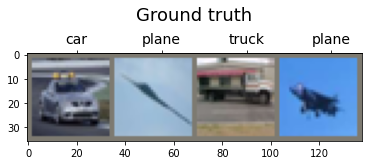

In [57]:
images, labels = dataiter.next()
imshow(images, labels)

In [58]:
model = ViT(
        img_size=32,          # Input image size
        in_channels=3,		# Number of channels for the image
        patch_size=4,         # How big our patches are
        embed_dim=768,		# Embedding dim
        num_layers=14,         # Number of transformer encoders
        num_heads=6,          # Number of attention heads
        attn_dropout=0.1,       # Attention Dropout
        proj_dropout=0.,       # (MHA) Projection Dropout
        mlp_dropout=0.1,       # (MHA) last layer dropout
        mlp_ratio=4,           # (MHA) Projection FF dimension
        n_classes=1000       # Number of classes to classify
        )
model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.8509, 0.5166, 0.5657, 0.2350, 0.2679, 0.0515, 0.5224, 0.9384, 0.2380,
         0.6444],
        [0.4639, 0.3484, 0.8767, 0.7527, 0.3637, 0.8151, 0.2511, 0.4645, 0.9062,
         0.5113],
        [0.6535, 0.9695, 0.8049, 0.8948, 0.5154, 0.1517, 0.9748, 0.8398, 0.9188,
         0.8354],
        [0.1434, 0.9538, 0.6967, 0.0508, 0.9077, 0.2365, 0.5638, 0.8485, 0.3834,
         0.7001]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.158454418182373


In [59]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(trainloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(trainloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [60]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(testloader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
